# Preperation

In [ ]:
import torch
import numpy as np
from torch import nn, optim
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets,transforms
import cv2
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import os
import torch.nn.functional as F
import random

from torchvision.models import resnet50, vgg16

from skimage import io, transform

from torchvision import transforms, utils
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split

!pip install -qU albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

!pip install grad-cam
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image

!pip install pretrainedmodels
import pretrainedmodels

RootDir = "/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project"
from google.colab import drive
drive.mount('/content/gdrive')

     |████████████████████████████████| 102 kB 5.6 MB/s 
     |████████████████████████████████| 47.8 MB 1.8 MB/s 
     |████████████████████████████████| 4.5 MB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.7-py3-none-any.whl size=25953 sha256=ab53f7b33bb6b4bb073d8e48ba248c6cffafa20ed13c7a20f50a0147ba2eee03
  Stored in directory: /root/.cache/pip/wheels/30/ab/9c/53c523785edffdc6c61755cf82e0dac3342d0d36190c187894
Successfully built grad-cam
     |████████████████████████████████| 58 kB 2.9 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=eaa6d4052fa5c090c45364ea087ddae773db7f08f918777b85d12a43a9a65e69
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels
Mounted at /content/gdrive


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
EPOCHS = 30
NUM_WORKERS = 4
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

In [ ]:
!cp "/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/zipped/cam_score_compressed.zip" .
!cp "/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/zipped/image_compresse.zip" .
!cp "/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/zipped/trimaps.zip" .

In [ ]:
!unzip "trimaps.zip"
!unzip "cam_score_compressed.zip"
!unzip "image_compresse.zip"

# Dataset

In [ ]:
class PetDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None, resizer=None):
        self.label_data = pd.read_csv(csv_file, sep='\s+')
        self.root_dir = root_dir
        self.cam_dir = "/content/cam_score_compressed"
        self.mask_dir = "/content/trimaps_2compressed"
        self.transform = transform
        self.resizer = resizer

    def __len__(self):
        return len(self.label_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.label_data.iloc[idx, 0] + ".jpg")
        raw_image = io.imread(img_name)
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

        cam_path = os.path.join(self.cam_dir, self.label_data.iloc[idx, 0] + ".png")
        cam = io.imread(cam_path)

        mask_path = os.path.join(self.mask_dir, self.label_data.iloc[idx, 0] + ".png")
        mask = io.imread(mask_path)

        '''
        if self.transform:
            image = self.transform(image)
            # cam = self.resizer(cam)
            mask = self.resizer(mask)[0]
        '''

        if self.transform is not None:
            masks = [mask, cam]
            augmentations = self.transform(image=image, masks=masks)
            image = augmentations['image'] / 255.0
            mask = augmentations['masks'][0]
            cam = np.expand_dims(augmentations['masks'][1] / 255.0, 0)

        classid = self.label_data.iloc[idx, 1] - 1 # 0:36 class ids
        species = self.label_data.iloc[idx, 2] - 1 # 0:Cat 1:Dog
        sample = {'image': image,
                  'mask': mask,
                  'cam': cam,
                  'classid': classid,
                  'species': species,
                  'img_name':img_name
                  }

        return sample 

In [ ]:
augNtransform = A.Compose([
    # A.Resize(128,128),
    A.Rotate(limit=35,p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    ToTensorV2()  
])

pet_dataset = PetDataset(csv_file="/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/annotations/trainval.txt",
                         root_dir="/content/image_compressed",
                         transform = augNtransform
                         )

test_dataset = PetDataset(csv_file="/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/annotations/test.txt",
                         root_dir="/content/image_compressed",
                         transform = augNtransform
                          )

classid = pet_dataset.label_data.iloc[:, 1]
index = np.array(range(len(classid)))
train_idx, val_idx, y_train, y_test = train_test_split(index, classid, test_size=0.1, stratify=classid)

train_dataset = torch.utils.data.Subset(pet_dataset, train_idx)
val_dataset = torch.utils.data.Subset(pet_dataset, val_idx)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Visualize

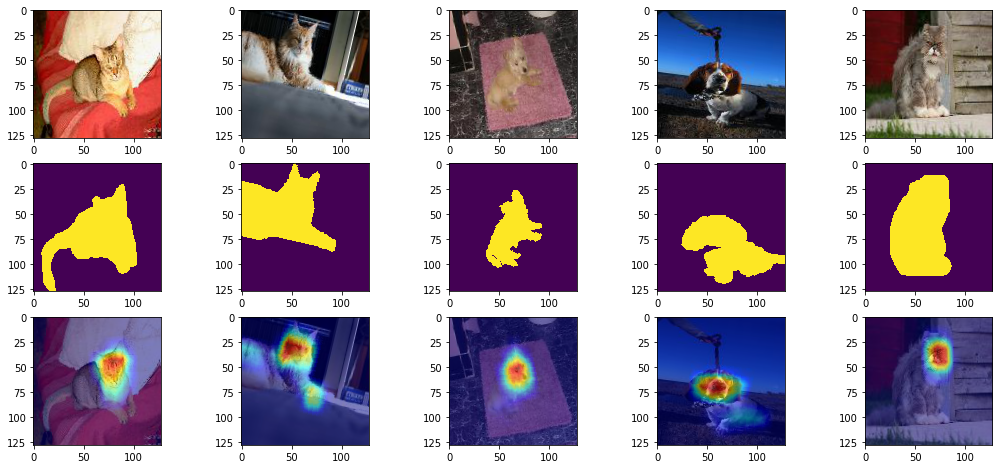

In [ ]:
plt.figure(figsize =(18, 8))
posi = 1
for i in random.sample(range(0, 1000), 5):
    data = pet_dataset[i]
    img = data['image']
    ax = plt.subplot(3, 5, posi)
    ax.imshow(img.permute(1, 2, 0))

    mask = data['mask']
    ax = plt.subplot(3, 5, posi + 5)
    # ax.imshow((mask * img.numpy()).transpose(1, 2, 0))
    ax.imshow(mask)

    cam = np.squeeze(data['cam'])
    visualization = show_cam_on_image(img.permute(1, 2, 0).numpy(), cam, use_rgb=True)
    ax = plt.subplot(3, 5, posi + 10)
    ax.imshow(visualization)
    posi += 1

# Understand Conv2D

In [ ]:
# Calculate by calling method
input = torch.arange(27, requires_grad=False).view(1, 3, 3, 3).float()
mapping = nn.Conv2d(3, 2, kernel_size=2, stride=1)
output = mapping(input)
print(input)
print(output)

tensor([[[[ 0.,  1.,  2.],
          [ 3.,  4.,  5.],
          [ 6.,  7.,  8.]],

         [[ 9., 10., 11.],
          [12., 13., 14.],
          [15., 16., 17.]],

         [[18., 19., 20.],
          [21., 22., 23.],
          [24., 25., 26.]]]])
tensor([[[[0.6389, 0.8141],
          [1.1646, 1.3399]],

         [[3.0135, 3.3315],
          [3.9677, 4.2858]]]], grad_fn=<ThnnConv2DBackward0>)


In [ ]:
# Calculate the result of upper left corner by hand, the output should be the same
# print("Filters:\n", mapping.weight)
# print("Bias:\n",mapping.bias)
first_block = input[:, :, :2, :2]
print("First block:\n", first_block)
apply_kernal = first_block * mapping.weight # element-wize product (input with each 3 kernels of 2 filters)
# print("Element-wize Product:\n", apply_kernal)
output_first_block_filter1 = apply_kernal[0].sum() + mapping.bias[0]
output_first_block_filter2 = apply_kernal[1].sum() + mapping.bias[1]
print(output_first_block_filter1)
print(output_first_block_filter2)

First block:
 tensor([[[[ 0.,  1.],
          [ 3.,  4.]],

         [[ 9., 10.],
          [12., 13.]],

         [[18., 19.],
          [21., 22.]]]])
tensor(0.6389, grad_fn=<AddBackward0>)
tensor(3.0135, grad_fn=<AddBackward0>)


# Classification model

In [ ]:
class ResNetV2(nn.Module):
    def __init__(self):
        super(ResNetV2, self).__init__()
        self.model = pretrainedmodels.__dict__["resnet50"](pretrained="imagenet")
        for name, param in self.model.named_parameters():        
            prefix = name[:4]
            if prefix != "last":
              param.requires_grad = False

        self.fc = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=2048*4*4, out_features=2048, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=2048, out_features=512, bias=True),
            nn.ReLU(inplace=True)
        )
        self.out = nn.Linear(in_features=512, out_features=2, bias=True)
        
    def forward(self, x): # 128 x 128
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = self.fc(x.reshape(bs, -1))
        label = self.out(x)
        return label

def train_clf(model, criterion, optimizer, n_epochs=40):
    valid_loss_max = 0.9 # Acc of saved model

    batch_size = 200
    for epoch in range(1, n_epochs):
      k = (epoch-1)*batch_size
      train = [0,1,2,3]
      train_loss = 0.0
      valid_loss = 0.0
      # train the model #
      model.train()
      for batch_idx, sample_batched in enumerate(train_dataloader):
            # importing data and moving to GPU
            image, label = sample_batched['image'].to(DEVICE).float(), sample_batched['species'].to(DEVICE)
            optimizer.zero_grad()
            output=model(image)

            loss = criterion(output, label)
            loss.backward()

            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
                
      # validate the model #
      model.eval()
      for batch_idx, sample_batched in enumerate(val_dataloader):
            image, label = sample_batched['image'].to(DEVICE).float(), sample_batched['species'].to(DEVICE)
            output = model(image)
            _, predicted = torch.max(output, 1)
            train_acc = torch.sum(predicted == label) / len(label)
            
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (train_acc - valid_loss))

      # print training/validation statistics 
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Acc: {:.6f}'.format(
          epoch, train_loss, valid_loss))
      
      ## TODO: save the model if validation loss has decreased
      if valid_loss > valid_loss_max:
          torch.save(model.state_dict(), '/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/model_clf.pt')
          print('Validation Acc Increased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_max,
          valid_loss))
          valid_loss_max = valid_loss
    # return trained model
    return model

In [ ]:
classifier = ResNetV2().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001, weight_decay=0.0001)
torch.cuda.empty_cache()
train_clf(classifier, criterion, optimizer, n_epochs=60)

Epoch 1, Batch 1 loss: 0.693368
Epoch 1, Batch 101 loss: 0.651995
Epoch: 1 	Training Loss: 0.639984 	Validation Acc: 0.877604
Epoch 2, Batch 1 loss: 0.317903
Epoch 2, Batch 101 loss: 0.274424
Epoch: 2 	Training Loss: 0.276114 	Validation Acc: 0.908854
Validation Acc Increased (0.900000 --> 0.908854).  Saving model ...
Epoch 3, Batch 1 loss: 0.279742
Epoch 3, Batch 101 loss: 0.264499
Epoch: 3 	Training Loss: 0.267460 	Validation Acc: 0.901042
Epoch 4, Batch 1 loss: 0.181993
Epoch 4, Batch 101 loss: 0.252699
Epoch: 4 	Training Loss: 0.254544 	Validation Acc: 0.914062
Validation Acc Increased (0.908854 --> 0.914062).  Saving model ...
Epoch 5, Batch 1 loss: 0.112314
Epoch 5, Batch 101 loss: 0.244577
Epoch: 5 	Training Loss: 0.244617 	Validation Acc: 0.908854
Epoch 6, Batch 1 loss: 0.167739
Epoch 6, Batch 101 loss: 0.230267
Epoch: 6 	Training Loss: 0.230457 	Validation Acc: 0.908854
Epoch 7, Batch 1 loss: 0.410794
Epoch 7, Batch 101 loss: 0.236506
Epoch: 7 	Training Loss: 0.238765 	Validat

ResNetV2(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [ ]:
acc = 0.0
counter = 0
for batch_idx, sample_batched in enumerate(test_dataloader):
  counter += 1
  image, label = sample_batched['image'].to(DEVICE).float(), sample_batched['species'].to(DEVICE)
  output = classifier(image)
  _, predicted = torch.max(output, 1)
  acc += torch.sum(predicted == label) / len(label)
acc = acc / counter
print(acc)

tensor(0.9133, device='cuda:0')


# Actual model.  

As we learned above that the convlution would sum up output of all input channels.   
For this reason. We can't simply add CAM as the Fourth Channel.   
Therefore, we decide to use CAM to weight filters before out convolution

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Att(nn.Module):
  """Downscaling CAM and calculate attention score"""
  def __init__(self, in_channels, out_channels):
    super(Att, self).__init__()
    self.filters = out_channels
    self.model = nn.Sequential(
        nn.Linear(in_channels, 2048),
        nn.ReLU(),
        nn.Linear(2048, out_channels),
        nn.Softmax(dim=1)
    )
  def forward(self, x):
    bs = x.shape[0]
    out = self.model(x.view(bs, -1)) * self.filters
    return out

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2, att=None):
        bs = x1.shape[0]
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1) # new Channel number = x1 channel number + x2.channel number
        if att is not None:
            x = x.view(bs, 128, -1)
            x = (att * x).view(bs, 128, 128, 128)
            x = F.relu(x)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        print("Initialize UNet")
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.inc_cam = DoubleConv(1, 16)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        bs, _, _, _ = x.shape
        x1 = self.inc(x) # [BS, 64, 128, 128]
        x2 = self.down1(x1) # [BS, 128, 64, 64]
        x3 = self.down2(x2) # [BS, 256, 32, 32]
        x4 = self.down3(x3) # [BS, 512, 16, 16]
        x5 = self.down4(x4) # [BS, 1024, 8, 8]

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

class UNetCam(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNetCam, self).__init__()
        print("Initialize UNetCam")
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.inc_cam = DoubleConv(1, 16)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

        self.down_cam1 = Down(16, 32)
        self.down_cam2 = Down(32, 64)
        self.down_cam3 = Down(64, 128)
        self.down_cam4 = Down(128, 64)
        self.attention = Att(4096, 128)

    def forward(self, x, cam):
        bs, _, _, _ = x.shape
        x1 = self.inc(x) # [BS, 64, 128, 128]
        x2 = self.down1(x1) # [BS, 128, 64, 64]
        x3 = self.down2(x2) # [BS, 256, 32, 32]
        x4 = self.down3(x3) # [BS, 512, 16, 16]
        x5 = self.down4(x4) # [BS, 1024, 8, 8]
        
        cam1 = self.inc_cam(cam)
        cam2 = self.down_cam1(cam1)
        cam3 = self.down_cam2(cam2)
        cam4 = self.down_cam3(cam3)
        cam5 = self.down_cam4(cam4)
        attention = self.attention(cam5).view(1, bs, 128, 1)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2).view(bs, 128, -1)
        # Apply attention to filters right before concat with original input
        x = (attention * x).view(bs, 128, 64, 64)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

class UNetCam2(nn.Module):
    # Utilize CAM for feature selection
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNetCam2, self).__init__()
        print("Initialize UNetCam2")
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.inc_cam = DoubleConv(3, 16)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

        self.down_cam1 = Down(16, 32)
        self.down_cam2 = Down(32, 64)
        self.down_cam3 = Down(64, 128)
        self.down_cam4 = Down(128, 128)
        self.attention = Att(4096 * 2, 128)

    def forward(self, x, cam):
        bs, _, _, _ = x.shape
        x1 = self.inc(x) # [BS, 64, 128, 128]
        x2 = self.down1(x1) # [BS, 128, 64, 64]
        x3 = self.down2(x2) # [BS, 256, 32, 32]
        x4 = self.down3(x3) # [BS, 512, 16, 16]
        x5 = self.down4(x4) # [BS, 1024, 8, 8]
        
        cam1 = self.inc_cam(cam)
        cam2 = self.down_cam1(cam1)
        cam3 = self.down_cam2(cam2)
        cam4 = self.down_cam3(cam3)
        cam5 = self.down_cam4(cam4)
        attention = self.attention(cam5).view(1, bs, 128, 1)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1, attention)
        logits = self.outc(x)
        return logits

class UNetClf(nn.Module):
    # Utilize pretrained classifier for feature selection
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNetClf, self).__init__()
        print("Initialize UNetClf")
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

        self.classifier = ResNetV2().to(DEVICE)
        self.classifier.load_state_dict(torch.load('/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/model_clf.pt'))
        for param in self.classifier.parameters():
          param.requires_grad = False

        self.attention = Att(512, 128)

    def forward(self, x, cam):
        bs, _, _, _ = x.shape
        x1 = self.inc(x) # [BS, 64, 128, 128]
        x2 = self.down1(x1) # [BS, 128, 64, 64]
        x3 = self.down2(x2) # [BS, 256, 32, 32]
        x4 = self.down3(x3) # [BS, 512, 16, 16]
        x5 = self.down4(x4) # [BS, 1024, 8, 8]
        
        cam = self.classifier.model.features(cam)
        cam = self.classifier.fc(cam.reshape(bs, -1))
        attention = self.attention(cam).view(1, bs, 128, 1)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1, attention)
        logits = self.outc(x)
        return logits

## Some preliminary tests

In [ ]:
test_data1 = pet_dataset[0]
test_data2 = pet_dataset[1]
img = torch.cat([torch.unsqueeze(test_data1["image"], 0),
                 torch.unsqueeze(test_data2["image"], 0)], dim=0)
cam1 = torch.tensor(test_data1["cam"], dtype=torch.float32)
cam2 = torch.tensor(test_data2["cam"], dtype=torch.float32)
cam = torch.cat([torch.unsqueeze(cam1, 0),
                 torch.unsqueeze(cam2, 0)], dim=0)
_ = plt.imshow(img[0].permute(1, 2, 0))

In [ ]:
test_model = UNet2(3, 1).to(DEVICE)
output = test_model(img.to(DEVICE), cam.to(DEVICE))
print(output.shape)

torch.Size([2, 1, 128, 128])


In [ ]:
# Test how to apply attention on to each filter
test_att = torch.tensor([[1, 2, 3, 4],  # Attentions for 4 filters in batch[0]
                         [3, 4, 5, 0]]) # Attentions for 4 filters in batch[1]
test_att = test_att.view(1, 2, 4, 1)
test_map = torch.arange(32).view(2, 4, 4) # Flatten 2x2 filters to apply attention
print(test_att)
print(test_map)
print((test_att * test_map).view(2, 4, 2, 2)) # Restore the filter shape

tensor([[[[1],
          [2],
          [3],
          [4]],

         [[3],
          [4],
          [5],
          [0]]]])
tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [12, 13, 14, 15]],

        [[16, 17, 18, 19],
         [20, 21, 22, 23],
         [24, 25, 26, 27],
         [28, 29, 30, 31]]])
tensor([[[[  0,   1],
          [  2,   3]],

         [[  8,  10],
          [ 12,  14]],

         [[ 24,  27],
          [ 30,  33]],

         [[ 48,  52],
          [ 56,  60]]],


        [[[ 48,  51],
          [ 54,  57]],

         [[ 80,  84],
          [ 88,  92]],

         [[120, 125],
          [130, 135]],

         [[  0,   0],
          [  0,   0]]]])


# Trainer

In [ ]:
class Trainer:
  def __init__(self, experiment_name, model_path=None):
    self.experiment_name = experiment_name

    if experiment_name == "base_model":
      self.model = UNet(3, 1).to(DEVICE)
      self.best_loss = 0.24
    if experiment_name == "cam_model":
      self.model = UNetCam(3, 1).to(DEVICE)
      self.best_loss = 0.24
    if experiment_name == "clf_model":
      self.model = UNetClf(3, 1).to(DEVICE)
      self.best_loss = 0.24

    if model_path is not None:
      self.model.load_state_dict(torch.load(model_path))

    self.optimizer = optim.Adam(self.model.parameters(),lr=1e-5, weight_decay=0.0001)
    self.criterion = nn.BCEWithLogitsLoss()

    self.accuracy = 0.0
    self.iou = 0.0
    self.train_loss = []
    self.val_loss = []
      
  def fit(self, dataloader):
    print('-------------Training---------------')
    self.model.train()
    train_running_loss = 0.0
    counter=0
    num_batches = int(len(classid) // BATCH_SIZE)
    for i, data in tqdm(enumerate(dataloader), total=104):
        counter+=1
        image = data["image"].to(DEVICE)
        mask = data["mask"].to(DEVICE).float()
        cam = data["cam"].to(DEVICE).float()
        self.optimizer.zero_grad()
        if self.experiment_name == "base_model":
          outputs = self.model(image)
        if self.experiment_name == "cam_model":
          outputs = self.model(image, cam)
        if self.experiment_name == "clf_model":
          outputs = self.model(image, image) # -----------------

        outputs =outputs.squeeze(1)
        loss = self.criterion(outputs,mask)
        train_running_loss += loss.item()
        loss.backward()
        self.optimizer.step()
    train_loss = train_running_loss/counter
    return train_loss

  def validate(self, dataloader):
    print("\n--------Validating---------\n")
    self.model.eval()
    valid_running_loss = 0.0
    counter = 0

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            counter+=1
            image = data["image"].to(DEVICE)
            mask = data["mask"].to(DEVICE).float()
            cam = data["cam"].to(DEVICE).float()
            if self.experiment_name == "base_model":
              outputs = self.model(image)
            if self.experiment_name == "cam_model":
              outputs = self.model(image, cam)
            if self.experiment_name == "clf_model":
              outputs = self.model(image, image) # -----------------
            
            outputs =outputs.squeeze(1)
            loss = self.criterion(outputs,mask)
            valid_running_loss += loss.item()

    valid_loss = valid_running_loss/counter
    if valid_loss < self.best_loss:
      print("New Lower Val Loss: {:.2f} -> {:.2f}".format(self.best_loss, valid_loss))
      self.best_loss = valid_loss
      torch.save(self.model.state_dict(), f'/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/{self.experiment_name}2.pt')
    return valid_loss

  def train(self, Epochs, train_loader, val_loader):
    for epoch in range(Epochs):
      print(f"Epoch {epoch+1} of {Epochs}")
      train_epoch_loss = self.fit(train_loader)
      val_epoch_loss = self.validate(val_loader)
      self.train_loss.append(train_epoch_loss)
      self.val_loss.append(val_epoch_loss)
      print(f"Train Loss: {train_epoch_loss:.4f}")
      print(f'Val Loss: {val_epoch_loss:.4f}')

  def trainlog(self):
    plt.figure(figsize =(10, 8))
    plt.plot(self.train_loss, label="train loss")
    plt.plot(self.val_loss, label="val loss")

  def test(self, test_loader):
    counter = 0
    self.accuracy = 0.0
    self.iou = 0.0

    with torch.no_grad():
      for i, data in enumerate(test_loader):
          counter+=1
          image = data["image"].to(DEVICE)
          mask = data["mask"].to(DEVICE).float()
          cam = data["cam"].to(DEVICE).float()
          if self.experiment_name == "base_model":
              outputs = self.model(image)
          if self.experiment_name == "cam_model":
            outputs = self.model(image, cam)
          if self.experiment_name == "clf_model":
            outputs = self.model(image, image) # -----------------

          outputs =outputs.squeeze(1)
          outputs[outputs>0.0] = 1.0
          outputs[outputs<=0.0] = 0.0

          correct = torch.sum(outputs == mask)
          self.accuracy += correct / (BATCH_SIZE * 128 * 128)

          tp = torch.sum(outputs * mask)
          self.iou += tp / (outputs.sum() + mask.sum() - tp)

    self.accuracy /= counter
    self.iou /= counter

    print("Acc: ", self.accuracy)
    print("IOU: ", self.iou)

  def visualize(self, test_dataset):
    plt.figure(figsize =(18, 8))
    posi = 1
    for i in random.sample(range(0, 1000), 5):
      data = test_dataset[i]
      image = data['image']
      mask = data['mask']
  
      ax = plt.subplot(3, 5, posi)
      ax.imshow(image.permute(1, 2, 0))
      ax = plt.subplot(3, 5, posi+5)
      ax.imshow(mask)
  
      ax = plt.subplot(3, 5, posi+10)
      img = data["image"].unsqueeze(0).to(DEVICE)
      cam = torch.tensor(data["cam"], dtype=torch.float32).unsqueeze(0).to(DEVICE)
      if self.experiment_name == "base_model":
        output = self.model(img)
      if self.experiment_name == "cam_model":
        output = self.model(img, cam)
      output = torch.squeeze(output)
      output[output>0.0] = 1.0
      output[output<=0.0]=0
      ax.imshow(output.cpu().detach().numpy())
      posi += 1

Initialize UNetCam
Epoch 1 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.39it/s]



--------Validating---------

Train Loss: 0.5974
Val Loss: 0.4841
Epoch 2 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.39it/s]



--------Validating---------

Train Loss: 0.4493
Val Loss: 0.4372
Epoch 3 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.4079
Val Loss: 0.3959
Epoch 4 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.3826
Val Loss: 0.3775
Epoch 5 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.3623
Val Loss: 0.3580
Epoch 6 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.3489
Val Loss: 0.3433
Epoch 7 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.3353
Val Loss: 0.3396
Epoch 8 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.3272
Val Loss: 0.3270
Epoch 9 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.3192
Val Loss: 0.3315
Epoch 10 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.3120
Val Loss: 0.3170
Epoch 11 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.3064
Val Loss: 0.3335
Epoch 12 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.3036
Val Loss: 0.3290
Epoch 13 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.2944
Val Loss: 0.3131
Epoch 14 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.2878
Val Loss: 0.3314
Epoch 15 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.2813
Val Loss: 0.3164
Epoch 16 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.2790
Val Loss: 0.2972
Epoch 17 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.2767
Val Loss: 0.3026
Epoch 18 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.2702
Val Loss: 0.2981
Epoch 19 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.2671
Val Loss: 0.3031
Epoch 20 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.2626
Val Loss: 0.2909
Epoch 21 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.2588
Val Loss: 0.2831
Epoch 22 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.2540
Val Loss: 0.2891
Epoch 23 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.2500
Val Loss: 0.2826
Epoch 24 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.39it/s]



--------Validating---------

Train Loss: 0.2507
Val Loss: 0.2693
Epoch 25 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.2440
Val Loss: 0.2987
Epoch 26 of 60
-------------Training---------------


100%|██████████| 104/104 [01:15<00:00,  1.38it/s]



--------Validating---------

Train Loss: 0.2409
Val Loss: 0.2756
Epoch 27 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.39it/s]



--------Validating---------

Train Loss: 0.2380
Val Loss: 0.2764
Epoch 28 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.39it/s]



--------Validating---------

Train Loss: 0.2353
Val Loss: 0.2762
Epoch 29 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.39it/s]



--------Validating---------

Train Loss: 0.2311
Val Loss: 0.2740
Epoch 30 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.39it/s]



--------Validating---------

Train Loss: 0.2306
Val Loss: 0.2694
Epoch 31 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.39it/s]



--------Validating---------

Train Loss: 0.2282
Val Loss: 0.2633
Epoch 32 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.39it/s]



--------Validating---------

Train Loss: 0.2206
Val Loss: 0.2634
Epoch 33 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.39it/s]



--------Validating---------

Train Loss: 0.2205
Val Loss: 0.2709
Epoch 34 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.39it/s]



--------Validating---------

Train Loss: 0.2206
Val Loss: 0.2705
Epoch 35 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.39it/s]



--------Validating---------

Train Loss: 0.2120
Val Loss: 0.2546
Epoch 36 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.39it/s]



--------Validating---------

Train Loss: 0.2133
Val Loss: 0.2635
Epoch 37 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2118
Val Loss: 0.2460
Epoch 38 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.39it/s]



--------Validating---------

Train Loss: 0.2089
Val Loss: 0.2536
Epoch 39 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.39it/s]



--------Validating---------

Train Loss: 0.2050
Val Loss: 0.2651
Epoch 40 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2045
Val Loss: 0.2545
Epoch 41 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2026
Val Loss: 0.2541
Epoch 42 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2005
Val Loss: 0.2615
Epoch 43 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1973
Val Loss: 0.2571
Epoch 44 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1920
Val Loss: 0.2538
Epoch 45 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1934
Val Loss: 0.2514
Epoch 46 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1884
Val Loss: 0.2492
Epoch 47 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1879
Val Loss: 0.2512
Epoch 48 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1851
Val Loss: 0.2478
Epoch 49 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1850
Val Loss: 0.2516
Epoch 50 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1853
Val Loss: 0.2479
Epoch 51 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1811
Val Loss: 0.2428
Epoch 52 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1778
Val Loss: 0.2615
Epoch 53 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1786
Val Loss: 0.2497
Epoch 54 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1792
Val Loss: 0.2295
Epoch 55 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1754
Val Loss: 0.2393
Epoch 56 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1763
Val Loss: 0.2456
Epoch 57 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1733
Val Loss: 0.2359
Epoch 58 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1728
Val Loss: 0.2523
Epoch 59 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1719
Val Loss: 0.2577
Epoch 60 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1719
Val Loss: 0.2404


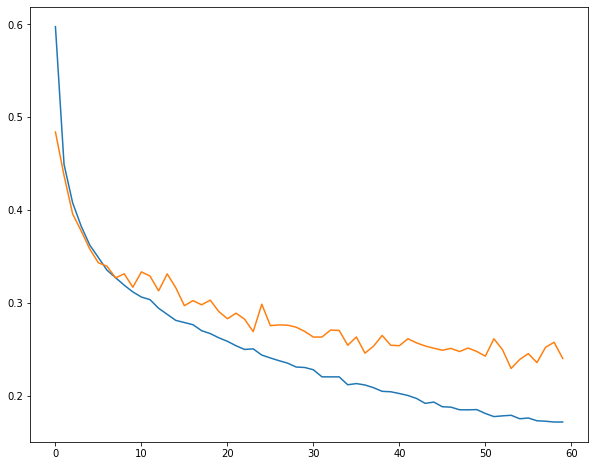

In [ ]:
torch.cuda.empty_cache()
train_cam = Trainer("cam_model")
train_cam.train(Epochs=60, train_loader=train_dataloader, val_loader=val_dataloader)
train_cam.trainlog()

In [ ]:
train_base = Trainer("base_model")
train_base.train(Epochs=60, train_loader=train_dataloader, val_loader=val_dataloader)
train_base.trainlog()

Initialize UNetCam
Epoch 1 of 60
-------------Training---------------


100%|██████████| 104/104 [01:09<00:00,  1.50it/s]



--------Validating---------

Train Loss: 0.5823
Val Loss: 0.4532
Epoch 2 of 60
-------------Training---------------


100%|██████████| 104/104 [01:11<00:00,  1.46it/s]



--------Validating---------

Train Loss: 0.4305
Val Loss: 0.4133
Epoch 3 of 60
-------------Training---------------


100%|██████████| 104/104 [01:12<00:00,  1.43it/s]



--------Validating---------

Train Loss: 0.3949
Val Loss: 0.3854
Epoch 4 of 60
-------------Training---------------


100%|██████████| 104/104 [01:13<00:00,  1.42it/s]



--------Validating---------

Train Loss: 0.3730
Val Loss: 0.3762
Epoch 5 of 60
-------------Training---------------


100%|██████████| 104/104 [01:13<00:00,  1.41it/s]



--------Validating---------

Train Loss: 0.3553
Val Loss: 0.3614
Epoch 6 of 60
-------------Training---------------


100%|██████████| 104/104 [01:13<00:00,  1.41it/s]



--------Validating---------

Train Loss: 0.3407
Val Loss: 0.3430
Epoch 7 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.3291
Val Loss: 0.3644
Epoch 8 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.3209
Val Loss: 0.3258
Epoch 9 of 60
-------------Training---------------


100%|██████████| 104/104 [01:13<00:00,  1.41it/s]



--------Validating---------

Train Loss: 0.3138
Val Loss: 0.3221
Epoch 10 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.3062
Val Loss: 0.3151
Epoch 11 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2958
Val Loss: 0.3163
Epoch 12 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2917
Val Loss: 0.3021
Epoch 13 of 60
-------------Training---------------


100%|██████████| 104/104 [01:13<00:00,  1.41it/s]



--------Validating---------

Train Loss: 0.2878
Val Loss: 0.3042
Epoch 14 of 60
-------------Training---------------


100%|██████████| 104/104 [01:13<00:00,  1.41it/s]



--------Validating---------

Train Loss: 0.2838
Val Loss: 0.3092
Epoch 15 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2789
Val Loss: 0.2921
Epoch 16 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2725
Val Loss: 0.2962
Epoch 17 of 60
-------------Training---------------


100%|██████████| 104/104 [01:13<00:00,  1.41it/s]



--------Validating---------

Train Loss: 0.2658
Val Loss: 0.2927
Epoch 18 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2644
Val Loss: 0.2918
Epoch 19 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2635
Val Loss: 0.2879
Epoch 20 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2576
Val Loss: 0.2744
Epoch 21 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2489
Val Loss: 0.2905
Epoch 22 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2490
Val Loss: 0.2919
Epoch 23 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2433
Val Loss: 0.2709
Epoch 24 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2396
Val Loss: 0.2749
Epoch 25 of 60
-------------Training---------------


100%|██████████| 104/104 [01:13<00:00,  1.41it/s]



--------Validating---------

Train Loss: 0.2376
Val Loss: 0.2781
Epoch 26 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2354
Val Loss: 0.2638
Epoch 27 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2312
Val Loss: 0.2606
Epoch 28 of 60
-------------Training---------------


100%|██████████| 104/104 [01:13<00:00,  1.41it/s]



--------Validating---------

Train Loss: 0.2304
Val Loss: 0.2638
Epoch 29 of 60
-------------Training---------------


100%|██████████| 104/104 [01:13<00:00,  1.41it/s]



--------Validating---------

Train Loss: 0.2249
Val Loss: 0.2547
Epoch 30 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2211
Val Loss: 0.2663
Epoch 31 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2207
Val Loss: 0.2645
Epoch 32 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2169
Val Loss: 0.2565
Epoch 33 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2146
Val Loss: 0.2522
Epoch 34 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2112
Val Loss: 0.2521
Epoch 35 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.41it/s]



--------Validating---------

Train Loss: 0.2091
Val Loss: 0.2598
Epoch 36 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2062
Val Loss: 0.2500
Epoch 37 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2042
Val Loss: 0.2533
Epoch 38 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.2026
Val Loss: 0.2503
Epoch 39 of 60
-------------Training---------------


100%|██████████| 104/104 [01:13<00:00,  1.41it/s]



--------Validating---------

Train Loss: 0.2019
Val Loss: 0.2459
Epoch 40 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1999
Val Loss: 0.2560
Epoch 41 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1985
Val Loss: 0.2729
Epoch 42 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1943
Val Loss: 0.2506
Epoch 43 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1920
Val Loss: 0.2538
Epoch 44 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1917
Val Loss: 0.2544
Epoch 45 of 60
-------------Training---------------


100%|██████████| 104/104 [01:13<00:00,  1.41it/s]



--------Validating---------

Train Loss: 0.1858
Val Loss: 0.2362
Epoch 46 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1856
Val Loss: 0.2443
Epoch 47 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1845
Val Loss: 0.2382
Epoch 48 of 60
-------------Training---------------


100%|██████████| 104/104 [01:13<00:00,  1.41it/s]



--------Validating---------

Train Loss: 0.1845
Val Loss: 0.2552
Epoch 49 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1843
Val Loss: 0.2459
Epoch 50 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1797
Val Loss: 0.2398
Epoch 51 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1758
Val Loss: 0.2416
Epoch 52 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1742
Val Loss: 0.2404
Epoch 53 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1756
Val Loss: 0.2387
Epoch 54 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1717
Val Loss: 0.2396
Epoch 55 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1709
Val Loss: 0.2329
Epoch 56 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1692
Val Loss: 0.2397
Epoch 57 of 60
-------------Training---------------


100%|██████████| 104/104 [01:13<00:00,  1.41it/s]



--------Validating---------

Train Loss: 0.1699
Val Loss: 0.2367
Epoch 58 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.41it/s]



--------Validating---------

Train Loss: 0.1671
Val Loss: 0.2396
Epoch 59 of 60
-------------Training---------------


100%|██████████| 104/104 [01:14<00:00,  1.40it/s]



--------Validating---------

Train Loss: 0.1652
Val Loss: 0.2392
Epoch 60 of 60
-------------Training---------------


100%|██████████| 104/104 [01:13<00:00,  1.41it/s]



--------Validating---------

Train Loss: 0.1657
Val Loss: 0.2329


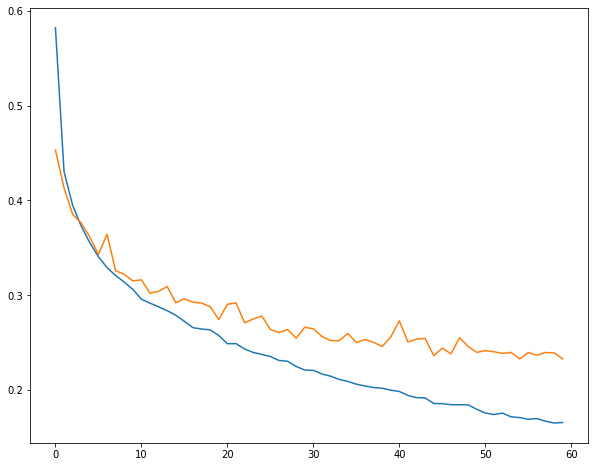

In [ ]:
train_clf = Trainer("cam_model")
train_clf.train(Epochs=60, train_loader=train_dataloader, val_loader=val_dataloader)
train_clf.trainlog()

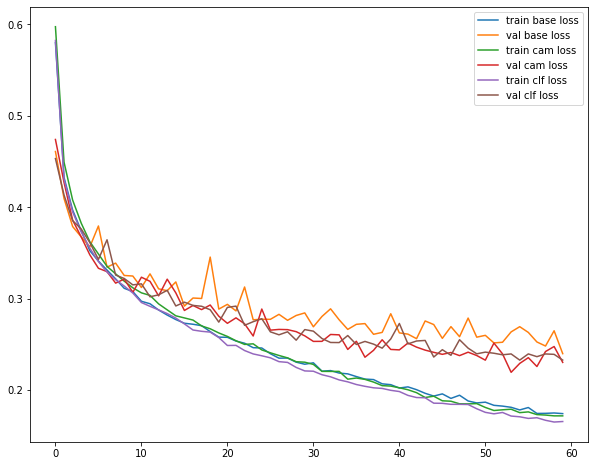

In [ ]:
plt.figure(figsize =(10, 8))
plt.plot(train_base.train_loss, label="train base loss")
plt.plot(train_base.val_loss, label="val base loss")
plt.plot(train_cam.train_loss, label="train cam loss")
plt.plot(train_cam.val_loss, label="val cam loss")
plt.plot(train_clf.train_loss, label="train clf loss")
plt.plot(train_clf.val_loss, label="val clf loss")
_ = plt.legend()

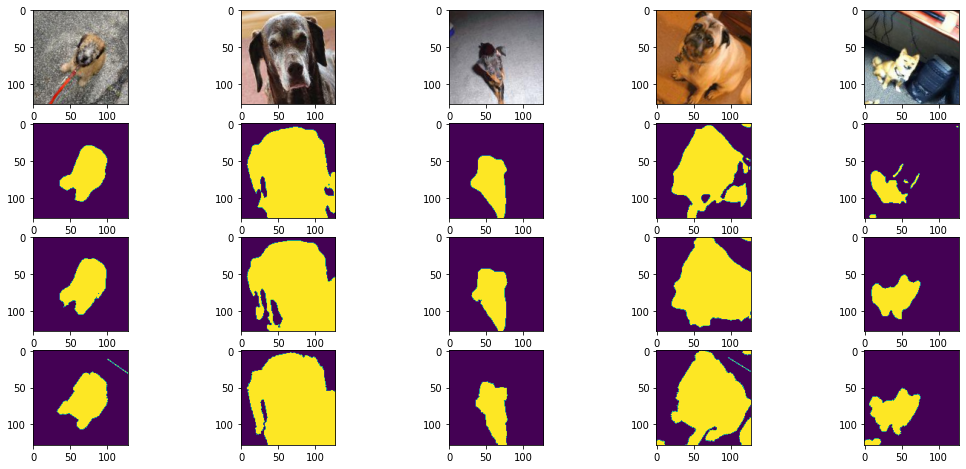

In [79]:
plt.figure(figsize =(18, 8))
posi = 1
# model_base = UNet(3, 1).to(DEVICE)
# model_cam = UNetCam(3, 1).to(DEVICE)
# model_base.load_state_dict(torch.load("/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/base_model.pt"))
# model_cam.load_state_dict(torch.load("/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/cam_model.pt"))
model_base = train_base.model
model_cam = train_clf.model
model_clf = train_cam.model

for i in random.sample(range(0, 1000), 5):
    data = train_dataset[i]
    image = data['image']
    img = data["image"].unsqueeze(0).to(DEVICE)

    ax = plt.subplot(4, 5, posi)
    ax.imshow(image.permute(1, 2, 0))

    ax = plt.subplot(4, 5, posi+5)
    out_base = model_base(img)
    out_base = torch.squeeze(out_base)
    out_base[out_base>0.0] = 1.0
    out_base[out_base<=0.0]=0
    ax.imshow(out_base.cpu().detach().numpy())

    ax = plt.subplot(4, 5, posi+10)
    cam = torch.tensor(data["cam"], dtype=torch.float32).unsqueeze(0).to(DEVICE)
    out_cam = model_cam(img, cam)
    out_cam = torch.squeeze(out_cam)
    out_cam[out_cam>0.0] = 1.0
    out_cam[out_cam<=0.0]=0
    ax.imshow(out_cam.cpu().detach().numpy())

    ax = plt.subplot(4, 5, posi+15)
    output_clf = model_clf(img, img)
    output_clf = torch.squeeze(output_clf)
    output_clf[output_clf>0.0] = 1.0
    output_clf[output_clf<=0.0]=0
    ax.imshow(output_clf.cpu().detach().numpy())
    posi += 1